In [444]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import emcee
import pandas as pd
from scipy import integrate

In [356]:
us_confirmed = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [357]:
def get_us_data(state,window = 5):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:].diff()  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:].diff()  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    df = df.rolling(window=window).mean() # rolling mean window to smoothen out data
    df = df[window:].round()
    return df

In [358]:
colorado = get_us_data('Colorado')

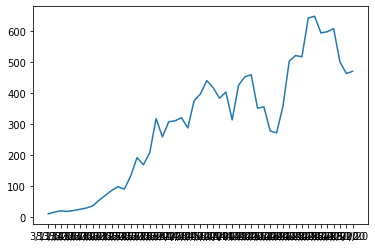

In [359]:
plt.plot(colorado.confirmed)

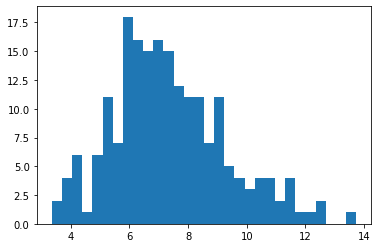

In [420]:
s, loc, scale = 0.25,0,7
gamma = stats.lognorm.rvs(s,loc,scale,size=200)
gamma = 1/gamma
plt.hist(1/gamma,bins=30)
plt.show()

In [437]:
def draw_gamma():
    s, loc, scale = 0.25,0,7
    gamma = stats.lognorm.rvs(s,loc,scale)
    return 1/gamma
    

In [361]:
r0_grid = np.linspace(0,5,num=1000)

In [362]:
# predict new cases today, given yesterday's cases,gamma,effective R
def newcases(yesterday_cases,gamma,R):
    out = yesterday_cases
    out *= np.e**(gamma*(R-1))
    return out



In [363]:
def r0_lhood(r0,gamma,yest_nc,today_nc,tol = 1e-6):
    prediction = newcases(yest_nc,gamma,r0)
    lhood = stats.poisson.logpmf(today_nc,prediction + tol)
    return lhood

Makes sense, Now do it for colorado....

In [364]:
print(newcases(colorado.confirmed[0],0.14,2))
print(colorado.confirmed[1])

10.352464189715047
15.0


In [365]:
stats.poisson.pmf(3,4.00001)

0.19536632639490653

In [376]:
def bayes_update(confirmed_vals,gamma,sigma=0.3):
    # Compute likelihoods
    likehoods = []
    for i in range(len(colorado)-1):
        yesterday = colorado.confirmed.values[i]
        today = colorado.confirmed.values[i+1]
        pmf = np.e**r0_lhood(r0_grid,gamma,yesterday,today)
        pmf /= np.sum(pmf)
        likehoods.append(pmf)
    likehoods = np.array(likehoods)
    
    # Process matrix governs random perturbations to R0 over time
    process_matrix = stats.norm(loc=r0_grid,
                                  scale=sigma
                                 ).pdf(r0_grid[:, None]) 

    # Now compute posteriors using previous posterior as new prior

    posteriors = []
    prior = np.ones(len(r0_grid))/len(r0_grid)

    for i in range(len(colorado) - 1):
        posterior = likehoods[i] * prior
        posterior /= np.sum(posterior)
        posteriors.append(posterior)    
        prior = process_matrix @ posterior

    posteriors = np.array(posteriors)
    
    return likehoods,posteriors

In [377]:
likehoods, posteriors = bayes_update(colorado.confirmed.values,1/7)

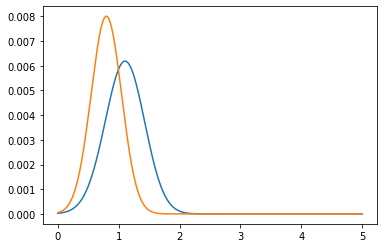

In [405]:
plt.plot(r0_grid,likehoods[-1])
plt.plot(r0_grid,posteriors[-1])

In [406]:
def mu_std(dist_array):
    mu = np.sum(dist_array * r0_grid)/np.sum(dist_array)
    
    sigma = (r0_grid - mu)**2 * dist_array
    sigma = np.sqrt(np.sum(sigma))
    
    sigma /= np.sum(dist_array)
    
    return mu,sigma
    
    

In [407]:
mu_list = np.zeros(len(posteriors))
std_list = np.zeros(len(posteriors))

for i in range(len(posteriors)):
    mu_list[i],std_list[i] = mu_std(posteriors[i])
    

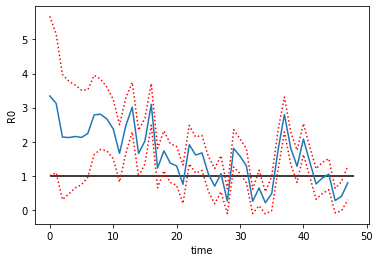

In [417]:
plt.plot(mu_list)
plt.plot(mu_list + 2*std_list,'r:')
plt.plot(mu_list - 2*std_list,'r:')
plt.hlines(1,0,len(posteriors))
plt.xlabel('time')
plt.ylabel('R0')
plt.show()


In [439]:

# Now take into effects for all gammas:
current_posterior = np.zeros(len(r0_grid))
current_likehood = np.zeros(len(r0_grid))

for _ in range(100):
    g = draw_gamma()
    l,p = bayes_update(colorado.confirmed.values,g)
    
    # only keep latest estimate of likelihood and posterior
    current_posterior += l[-1]
    current_posterior += p[-1]


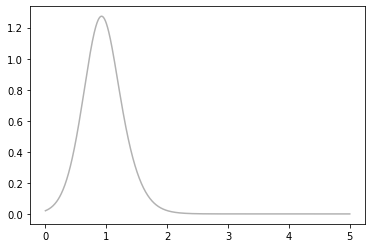

In [440]:
plt.plot(r0_grid,current_posterior,alpha = 0.3,color = 'black')

Now extrapolate to calculate number of cases at current value of R0

In [453]:
cdf = integrate.cumtrapz(current_posterior,x=r0_grid,)
u = np.random.rand()

loc = np.argmin(np.abs(cdf - u))
r0_grid[loc]

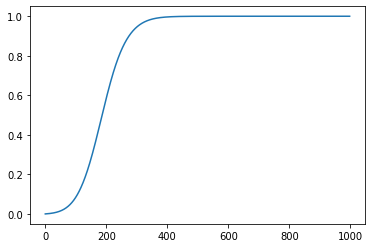

In [447]:
plt.plot(cdf)

In [523]:
def draw_r0(posterior,size = 1):
    cdf = integrate.cumtrapz(posterior,x=r0_grid)
    
    samples = np.zeros(size)
    for i in range(size):
        u = np.random.rand()

        loc = np.argmin(np.abs(cdf - u))
        samples[i] = r0_grid[loc]
        
        
    if size == 1: 
        return samples[0]
    else:
        return samples
    

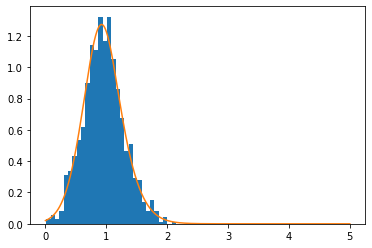

In [524]:
plt.hist(draw_r0(current_posterior,size=1000),bins=30,density=True)
plt.plot(r0_grid,current_posterior)

In [ ]:
time = np.arange(len(colorado.confirmed))

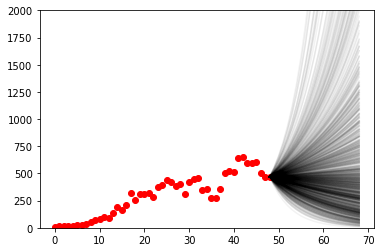

In [618]:
time = np.arange(len(colorado.confirmed))
plt.plot(time, colorado.confirmed,'ro')

future_days = 20

for i in range(1000):
    g = draw_gamma()
    r = draw_r0(current_posterior)

    extrpolations = [colorado.confirmed[-1]]
    for i in range(future_days):
        tomorrow = newcases(extrpolations[-1],g,r)
        extrpolations.append(tomorrow)
    
    future_time = np.arange(len(time)-1,len(time) + 20)
    plt.plot(future_time,extrpolations,alpha = 0.05,color = 'black')
    plt.ylim(0,2000)
    


#### This is straight up model predictions. How do we predict what the actual number of cases is going to be